In [1]:
import datefinder
import pandas as pd
from bs4 import BeautifulSoup
import os
import glob
import unidecode
from collections import defaultdict
import codecs
from tqdm import tqdm_notebook as tqdm
import datetime

In [149]:
council_meetings = glob.glob('../council_meetings/*/*')

In [150]:
meeting_dfs = []

In [276]:
for meeting_file_path in tqdm(council_meetings):
    html = codecs.open(meeting_file_path, encoding='utf-8').read()
    soup = BeautifulSoup(html, 'lxml')

    ## get date
    meeting_file = os.path.basename(meeting_file_path)
    fp_datepart = meeting_file.split('_')[1].replace('.htm', '')
    minutes_date = datetime.datetime.strptime(fp_datepart, '%m%d%Y')
    
    ## get all links
    minute_links = pd.Series(soup.find_all('a', href=lambda href: href and "cityclerk.lacity.org" in href))

    ## if links exist, parse...
    if len(minute_links)> 0:
        try:
            metadata_df = pd.concat([
                minute_links.apply(lambda x: x['href']).to_frame('link'),
                minute_links.apply(lambda x: x.get_text()).apply(unidecode.unidecode).to_frame('bill_number'),
            ], axis=1).set_index('bill_number')

            ## get text
            htmnl_text = unidecode.unidecode(soup.get_text())
            html_lines = list(map(lambda x: x.strip(), htmnl_text.split('\n')))

            ## parse text
            minutes_metadata = defaultdict(list)
            in_bill = False
            for line in html_lines:
                if line in metadata_df.index:
                    in_bill = line

                if in_bill:
                    minutes_metadata[in_bill].append(line)

            ## put it together
            metadata_df = metadata_df.merge(pd.Series(minutes_metadata).to_frame('text'), left_index=True, right_index=True)
            metadata_df['text'] = (
                metadata_df
                 .apply(lambda x: list(filter(lambda y: (y != '') and (y != x.name), x['text'])), axis=1)
                 .str.join(' ')
            )
            metadata_df['date'] = minutes_date

            meeting_dfs.append(metadata_df)
        except:
            print('failed on %s...' % meeting_file)

failed on clkreferralmemo992789_01122015.htm...
failed on clkreferralmemo9103082_04252016.htm...


In [277]:
all_meetings_dfs = pd.concat(meeting_dfs)

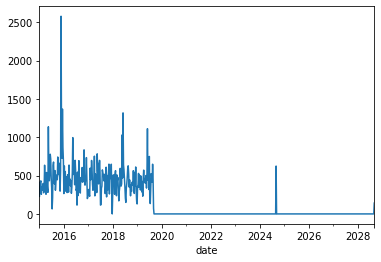

In [278]:
%matplotlib inline
all_meetings_dfs.assign(c=1).groupby(pd.Grouper(key='date', freq='7D'))['c'].sum().plot()

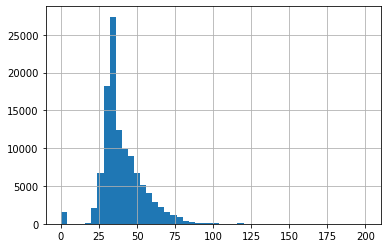

In [279]:
all_meetings_dfs['text'].str.split().str.len().hist(bins=50, range=(0, 200))

In [293]:
import util
from importlib import reload
import swifter

In [295]:
reload(util)

<module 'util' from 'C:\\Users\\alexa\\Projects\\usc-research\\newspaper-pages\\notebooks\\util.py'>

In [ ]:
all_meetings_dfs['processed_text'] = all_meetings_dfs['text'].swifter.apply(util.preprocess)

In [303]:
all_meetings_dfs.to_csv("../council_meetings/processed_council_meetings.csv")

# Parse City Council Meeting Minute Files

In [37]:
from bs4 import BeautifulSoup
from xml.etree import ElementTree as ET
import re
import datetime
from tqdm import tqdm_notebook as tqdm

In [21]:
council_action_files = glob.glob('../council_meetings/meetings/raw_html/*')
council_action_files = list(filter(lambda x: 'clkcouncilactions' in x, council_action_files))

In [ ]:
all_output = []
for council_action_file in tqdm(council_action_files):
    fn_date = re.findall('\_(\d\d)(\d\d)(\d\d\d\d).html', council_action_file.lower())
    if len(fn_date) != 1:
        print('error')
        print(council_action_file)

    month, day, year = fn_date[0]
    fn_date = datetime.datetime(int(year), int(month), int(day))
    
    soup = BeautifulSoup(open(council_action_file, encoding='latin1').read())
    ## get tables
    tables = soup.findAll('table')
    content_tables = tables[1:]
    ## parse output from tables
    output =[]
    to_append = ''
    appending = False
    for t in content_tables:
        t = t.get_text()
        if appending:
            if len(to_append) < 1000:
                to_append += ' ' + t
            else:
                output.append(to_append)
                to_append = ''
                appending = False

        if 'ITEM NO.' in t:
            appending = False
            to_append = ''
            if len(t) < 15:
                to_append += t
                appending = True
            else:
                output.append(t)

    for o in output:
        text = unidecode.unidecode(o)
        item_no = re.findall('(ITEM NO.\(\d+\))', text)
        if len(item_no) != 1:
            print('item-parsing error')
            print(text.replace('\n', '')[:100] + '...')
        all_output.append({
            'item_num': item_no[0],
            'date': fn_date,
            'text': text
        })

In [207]:
all_output_df = pd.DataFrame(all_output).assign(item_num=lambda df: df['item_num'].str.get(0))

In [212]:
import matplotlib.pyplot as plt
%matplotlib inline

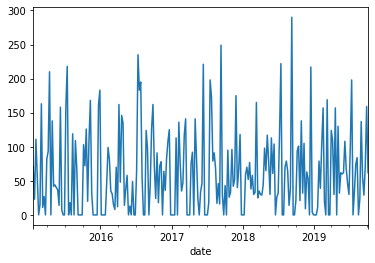

In [218]:
all_output_df.assign(c=1).groupby(pd.Grouper(key='date', freq='7D'))['c'].sum().plot()

In [222]:
all_meetings_df = all_output_df

In [224]:
all_referrals_dfs = pd.read_csv("../council_meetings/referrals/processed_council_meetings.csv", index_col=0)

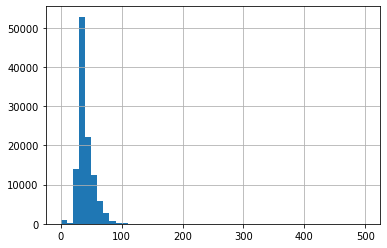

In [250]:
all_referrals_dfs['text'].str.split().str.len().hist(range=(0, 500), bins=50)

In [240]:
len(all_meetings_df['text'][400].split())

100

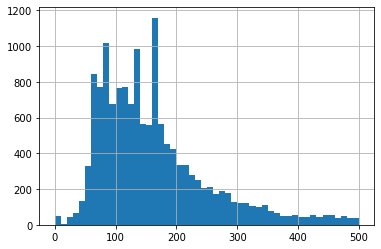

In [251]:
all_meetings_df['text'].str.split().str.len().hist(range=(0, 500), bins=50)

In [323]:
import spacy
import re
nlp = spacy.load('en_core_web_lg')
def preprocess(body, nlp=nlp):
    ## 
    salient_lines = list(filter(get_salient_lines, body.split('\n')))
    text = ' '.join(salient_lines)
    
    ## splice irrelevant numbers and punctuation
    text = text.replace('ITEM NO.', ' ')
    text = re.sub('\d', ' ', text)
    text = ' '.join(text.split())
    text = re.sub('\([A-Z]*\s*\)', ' ', text)
    text = ' '.join(text.replace('-', ' ').replace('$', ' ').replace(',', ' ').split())
    
    ## cut sentence fragments.
    doc = nlp(text)
    sentences = list(filter(lambda x: len(x.text.split())>5, doc.sents))
    
    ## 
    text = [word.text for sent in sentences for word in sent]
    body = ' '.join(text)

    ### other cleanup
    body = body.lower()
    body = body.strip()
    ## return 
    return body

In [321]:
def get_salient_lines(text):
    words = text.split()
    if len(words)>0:
        is_upper =  words[0].isupper()
        if is_upper:
            return (
                'TIME LIMIT FILE' not in text and
                'LAST DAY FOR COUNCIL ACTION' not in text
            )
    else:
        return False

In [334]:
preprocessed_meetings = []
for meeting in tqdm(all_meetings_df['text']):
    preprocessed_meetings.append(preprocess(meeting))

In [336]:
all_meetings_df['processed_text'] = preprocessed_meetings

In [339]:
all_meetings_df.to_csv('../council_meetings/meetings/all_meetings_df_processed.csv')

In [340]:
pd.concat([
    all_meetings_df,
    all_referrals_dfs
], sort=True).to_csv('../council_meetings/all_items_df_processed.csv')

In [342]:
pd.concat([
    all_meetings_df,
    all_referrals_dfs
], sort=True)['processed_text'].to_csv('../council_meetings/data.tsv', index=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  after removing the cwd from sys.path.


In [4]:
! wc -l ..\\council_meetings\\data.tsv

128405 ..\\council_meetings\\data.tsv


# Read data

In [1]:
import pandas as pd

In [2]:
pd.read_csv('../council_meetings/data.tsv', sep='\t', header=-1).head()

,0
0,hearing protest appeals or objections to build...
1,cd negative declaration planning and land use ...
2,cd transportation committee report relative to...
3,personnel and animal welfare committee report ...
4,s s cd planning and land use management commit...
